# Community Detection via Qatalyst

### Introduction

Detection of densely connected communities amongst a network of nodes and linkages between nodes is a known critical problem in combinatorial optimization. Optimal partition of communities requires (1) highly densed connected communities, partitioned across (2) weakly connected nodes of other communites. Community detection is applicable in biology, chemistry, and social sciences, to name a few. To perform community detection, Qatalyst utilizes a QUBO community detection formulation for a given graph instance input.

### Objective

Partitioning of networks into high-quality communities, with respect to the modularity metric, which provides a measure of connectedness within communities.

### Qatalyst

#### I. Imports

In [1]:
from qci_client import QciClient
import numpy as np
import math
import networkx as nx

import itertools
import os
import sys

import helpers

import matplotlib.pyplot as plt
%matplotlib inline

#### II. Problem formulation

Example problem - karate club graph instance (formulated via NetworkX):
- 34 nodes, 78 edges

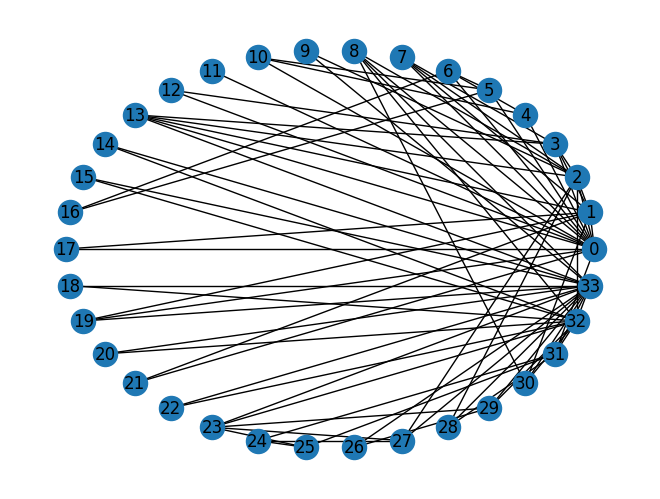

In [2]:
karate_club_graph = nx.karate_club_graph()
nx.draw_circular(karate_club_graph, with_labels=True)

We drop `'weight'` attribute associated with the graph instance, given that this is an unweighted graph problem:

In [3]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

In [4]:
drop_weights(karate_club_graph)

#### III. Client request parameters
- `alpha`, `beta`: hyperparameters for weighted importance of objective (`alpha`) versus constraint (`beta`)
- `n_samples`: number of samples (size of distribution to collect)
- `num_communities`: number of communities
- `sampler_type`: `"eqc1"` or `"csample"`
- `job_type`: `"unipartite-community-detection"`

In [5]:
# Constraint-objective hyperparameters
alpha = 5
beta = 1
# Num samples
n_samples = 1
# Number of partitions
num_communities = 4

# Job and sampler type
sampler_type = "eqc1"

job_type = "unipartite-community-detection"

#### IV. Instantiate client, pass job parameters and execute
- Requirement: `QciClient` client token
- Preliminary: Use `upload_file()` of `QciClient` class instance to upload problem and retrieve `file_id` 
- Next: Pass `file_id`, alongside with the above parameters, to request body call, `build_job_body()` of `QciClient` class
- Last: Execute job with `process_job()` of `QciClient` class instance

In [6]:
# Upload, Build, and Process
url = "https://api.qci-next.com"
q1 = QciClient(api_token=os.getenv("QCI_TOKEN"), url=url)

In [7]:
file_id = q1.upload_file(karate_club_graph, file_type="graph")["file_id"]
job_body = q1.build_job_body(job_type=job_type, graph_file_id=file_id, 
                             job_tags=["example", "cd", "!"], 
                             job_params={"sampler_type": sampler_type,
                                         "n_samples": n_samples, 
                                         "alpha": alpha,
                                         "num_communities": num_communities})

res = q1.process_job(job_type=job_type, job_body=job_body, wait=True)

{'file_type': 'graph', 'file_name': 'graph.json', 'directed': False, 'multigraph': False, 'graph': {'name': "Zachary's Karate Club"}, 'links': [{'source': 0, 'target': 1}, {'source': 0, 'target': 2}, {'source': 0, 'target': 3}, {'source': 0, 'target': 4}, {'source': 0, 'target': 5}, {'source': 0, 'target': 6}, {'source': 0, 'target': 7}, {'source': 0, 'target': 8}, {'source': 0, 'target': 10}, {'source': 0, 'target': 11}, {'source': 0, 'target': 12}, {'source': 0, 'target': 13}, {'source': 0, 'target': 17}, {'source': 0, 'target': 19}, {'source': 0, 'target': 21}, {'source': 0, 'target': 31}, {'source': 1, 'target': 2}, {'source': 1, 'target': 3}, {'source': 1, 'target': 7}, {'source': 1, 'target': 13}, {'source': 1, 'target': 17}, {'source': 1, 'target': 19}, {'source': 1, 'target': 21}, {'source': 1, 'target': 30}, {'source': 2, 'target': 3}, {'source': 2, 'target': 7}, {'source': 2, 'target': 8}, {'source': 2, 'target': 9}, {'source': 2, 'target': 13}, {'source': 2, 'target': 27}, {

#### V. Evaluate solution

In this example, we use our imported `graph_viz` package to map and plot our solution. The returned solution is a list of dicts, as shown below, where: 
- `'class'`: community index 
- `'id'`: node index:

In [8]:
res['results']['samples'][0][:5]

[{'class': 1, 'id': 0},
 {'class': 0, 'id': 1},
 {'class': 0, 'id': 2},
 {'class': 0, 'id': 3},
 {'class': 0, 'id': 7}]

`graph_viz` utilizes its `plot_graph_classes()` method to loop through the array of `dict` elements, place each `'id'` in one of k solution arrays, where k is the number of partitions, and then plot the array set using `networkx.draw_networkx_nodes()` (with a designated color set):

Modularity (alpha = 5): -1


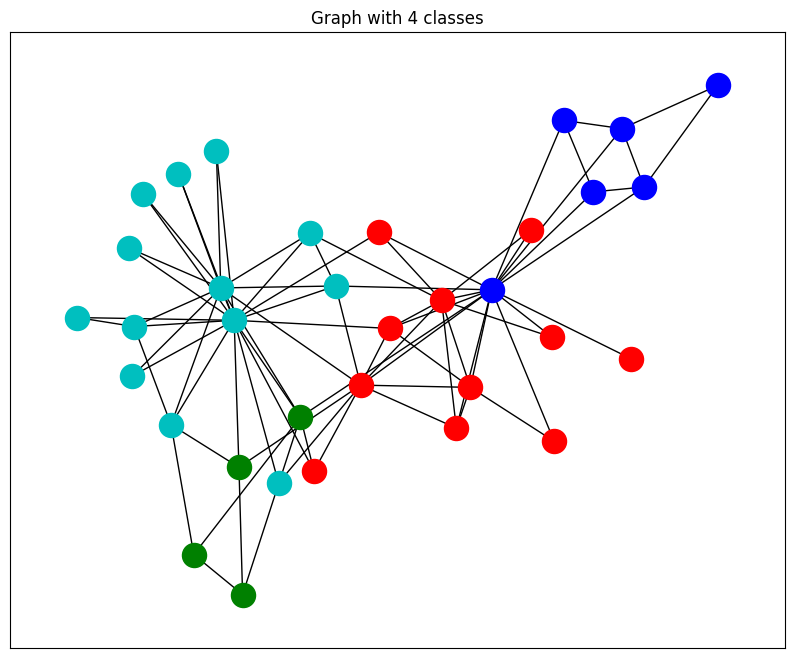

In [9]:
print(f'Modularity (alpha = {alpha}): ' + str(res['results']['modularity'][0]))
helpers.plot_graph_classes(karate_club_graph, res['results']['samples'][0], num_classes=num_communities)

#### 6. Further Analysis (Miscellaneous)

.no of nodes

In [10]:
num_nodes = karate_club_graph.number_of_nodes()
num_nodes

34

no. of edges

In [11]:
num_edges = karate_club_graph.number_of_edges()
num_edges

78

edge-density

In [12]:
edge_density = (2*num_edges)/(num_nodes*(num_nodes - 1))
edge_density

0.13903743315508021

Degrees analysis

Text(0, 0.5, '# of Nodes')

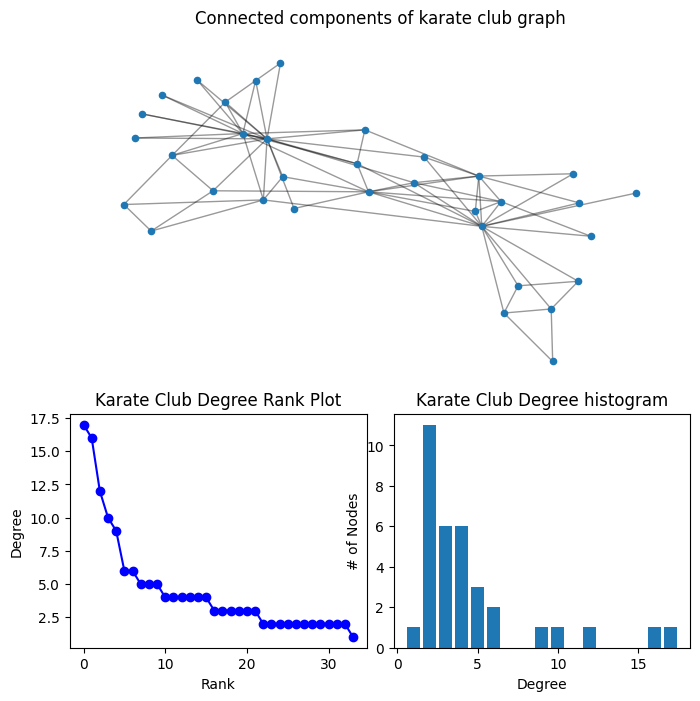

In [13]:
kc_degree_sequence = sorted((d for n, d in karate_club_graph.degree()), reverse=True)
kc_dmax = max(kc_degree_sequence)

kc_fig = plt.figure("Degree of a karate club graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
kc_axgrid = kc_fig.add_gridspec(5, 4)

kc_ax0 = kc_fig.add_subplot(kc_axgrid[0:3, :])
kc_cc = karate_club_graph.subgraph(sorted(nx.connected_components(karate_club_graph), key=len, reverse=True)[0])
kc_pos = nx.spring_layout(kc_cc, seed=10396953)
nx.draw_networkx_nodes(kc_cc, kc_pos, ax=kc_ax0, node_size=20)
nx.draw_networkx_edges(kc_cc, kc_pos, ax=kc_ax0, alpha=0.4)
kc_ax0.set_title("Connected components of karate club graph")
kc_ax0.set_axis_off()

kc_ax1 = kc_fig.add_subplot(kc_axgrid[3:, :2])
kc_ax1.plot(kc_degree_sequence, "b-", marker="o")
kc_ax1.set_title("Karate Club Degree Rank Plot")
kc_ax1.set_ylabel("Degree")
kc_ax1.set_xlabel("Rank")

kc_ax2 = kc_fig.add_subplot(kc_axgrid[3:, 2:])
kc_ax2.bar(*np.unique(kc_degree_sequence, return_counts=True))
kc_ax2.set_title("Karate Club Degree histogram")
kc_ax2.set_xlabel("Degree")
kc_ax2.set_ylabel("# of Nodes")

Shortest-path analysis

In [14]:
kc_pathlengths = []

print("source vertex {target:length, }")
for v in karate_club_graph.nodes():
    spl = dict(nx.single_source_shortest_path_length(karate_club_graph, v))
    print(f"{v} {spl} ")
    for p in spl:
        kc_pathlengths.append(spl[p])

print()
print(f"average shortest path length {sum(kc_pathlengths) / len(kc_pathlengths)}")

# histogram of path lengths
kc_dist = {}
for p in kc_pathlengths:
    if p in kc_dist:
        kc_dist[p] += 1
    else:
        kc_dist[p] = 1

print()
print("length #paths")
kc_verts = kc_dist.keys()
for d in sorted(kc_verts):
    print(f"{d} {kc_dist[d]}")

print()
# The minimum eccentricity
print(f"radius: {nx.radius(karate_club_graph)}")
print()
# The maximum eccentricity
print(f"diameter: {nx.diameter(karate_club_graph)}")
print()
# The eccentricity of a node v is the maximum distance from v to all other nodes in G.
print(f"eccentricity: {nx.eccentricity(karate_club_graph)}")
print()
# The set of nodes with eccentricity equal to radius.
print(f"center: {nx.center(karate_club_graph)}")
print()
# The set of nodes with eccentricity equal to the diameter.
print(f"periphery: {nx.periphery(karate_club_graph)}")
print()
# The density of undirected graphs: 2m/(n(n-1)), where m = no. of edges, n = no. of nodes
print(f"density: {nx.density(karate_club_graph)}")

source vertex {target:length, }
0 {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 10: 1, 11: 1, 12: 1, 13: 1, 17: 1, 19: 1, 21: 1, 31: 1, 9: 2, 16: 2, 24: 2, 25: 2, 27: 2, 28: 2, 30: 2, 32: 2, 33: 2, 14: 3, 15: 3, 18: 3, 20: 3, 22: 3, 23: 3, 26: 3, 29: 3} 
1 {1: 0, 0: 1, 2: 1, 3: 1, 7: 1, 13: 1, 17: 1, 19: 1, 21: 1, 30: 1, 4: 2, 5: 2, 6: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 27: 2, 28: 2, 31: 2, 32: 2, 33: 2, 14: 3, 15: 3, 16: 3, 18: 3, 20: 3, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 29: 3} 
2 {2: 0, 0: 1, 1: 1, 32: 1, 3: 1, 7: 1, 8: 1, 9: 1, 13: 1, 27: 1, 28: 1, 4: 2, 5: 2, 6: 2, 10: 2, 11: 2, 12: 2, 14: 2, 15: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 29: 2, 30: 2, 31: 2, 33: 2, 16: 3, 25: 3, 26: 3} 
3 {3: 0, 0: 1, 1: 1, 2: 1, 7: 1, 12: 1, 13: 1, 4: 2, 5: 2, 6: 2, 8: 2, 9: 2, 10: 2, 11: 2, 17: 2, 19: 2, 21: 2, 27: 2, 28: 2, 30: 2, 31: 2, 32: 2, 33: 2, 14: 3, 15: 3, 16: 3, 18: 3, 20: 3, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 29: 3} 
4 {4: 0, 0: 1, 10: 1, 6: 1, 1: 2, 2: 2, 

In [15]:
# print the adjacency list
for line in nx.generate_adjlist(karate_club_graph):
    print(line)

0 1 2 3 4 5 6 7 8 10 11 12 13 17 19 21 31
1 2 3 7 13 17 19 21 30
2 3 7 8 9 13 27 28 32
3 7 12 13
4 6 10
5 6 10 16
6 16
7
8 30 32 33
9 33
10
11
12
13 33
14 32 33
15 32 33
16
17
18 32 33
19 33
20 32 33
21
22 32 33
23 25 27 29 32 33
24 25 27 31
25 31
26 29 33
27 33
28 31 33
29 32 33
30 32 33
31 32 33
32 33
33


Eigenvalues

Largest eigenvalue: 1.7146113474736246
Smallest eigenvalue: -2.7755575615628914e-17


<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


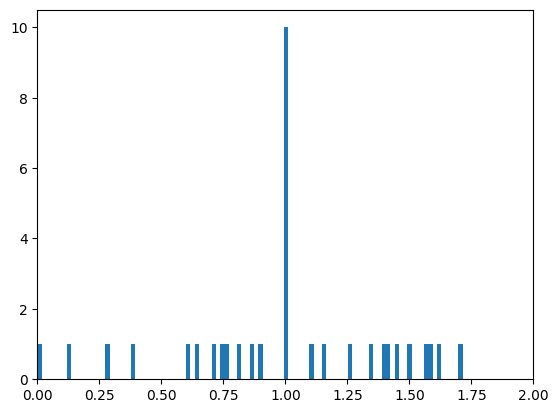

In [16]:
kc_L = nx.normalized_laplacian_matrix(karate_club_graph)
kc_e = np.linalg.eigvals(kc_L.toarray())
print("Largest eigenvalue:", max(kc_e))
print("Smallest eigenvalue:", min(kc_e))
plt.hist(kc_e, bins=100)  # histogram with 100 bins
plt.xlim(0, 2)  # eigenvalues between 0 and 2
plt.show()

#### Summary

We've shown the use of Qatalyst's `QciClient` class for instantiating and send a job request for executing community detection on a graph instance. User graph instances are expected to be problem specific, and the `"unipartite-community-detection"` job type of the job body should be specified to implement community detection optimization for the input graph instance passed to `upload_file()` (of the `QciClient` class instance). Last, we showed that the returned solutions are amenable to the NetworkX `draw_networkx_graph()` method, which was executed via the imported `graph_viz` package, for plotting the graph solution of the input problem instance.